In [ ]:
# Cell 1: imports and random seed
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os

# Optional: use scipy sparse eigs for larger graphs (not required here)
try:
    from scipy.sparse.linalg import eigs
    has_scipy = True
except Exception:
    has_scipy = False

np.random.seed(1)

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os# Cell 2: load Karate Club graph and fixed layout
G = nx.karate_club_graph()  # NetworkX nodes are 0..33 for Karate dataset

# fixed layout so plots across iterations are comparable
pos = nx.spring_layout(G, seed=42)  # seed ensures same layout every run

# create output directory for iteration plots
outdir = "karate_modularity_output"
os.makedirs(outdir, exist_ok=True)

In [ ]:
# Cell 3: modularity matrix and modularity scoring

def modularity_matrix(G, nodes=None):
    """
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os
  Compute modularity matrix B for the whole graph or restricted to nodes.
    If nodes is None -> full graph. If nodes is a sequence of nodes -> restrict rows/cols.
    """
    if nodes is None:
        nodes = list(G.nodes())
    n_all = G.number_of_nodes()
    m = G.number_of_edges()
    # map nodes->indices for submatrix
    nodes = list(nodes)
    idx = {v:i for i,v in enumerate(nodes)}
    k = np.array([G.degree(v) for v in nodes], dtype=float)
    # adjacency block
    A = np.zeros((len(nodes), len(nodes)), dtype=float)
    for i,u in enumerate(nodes):
        for j,v in enumerate(nodes):
            if G.has_edge(u,v):
                A[i,j] = 1.0
    # expected term (k k^T)/(2m) where k from full graph degrees but restricted to nodes
    # note: the expected term uses the degrees of the original graph (not just induced),
    # but for our removal/restricted block we still use the same formula (Degree vector restricted).
    KKt = np.outer(k, k) / (2.0*m)
    B = A - KKt
    return B, nodes

def modularity_of_partition(G, communities):
    """
    communities: list of lists of nodes (disjoint parts)
    returns modularity Q (the standard definition)
    """
    # use networkx modularity for correctness (for simple graphs)
    return nx.algorithms.community.quality.modularity(G, communities)

In [ ]:
# Cell 1: imports and random seed
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os

# Optional: use scipy sparse eigs for larger graphs (not required here)
try:
    from scipy.sparse.linalg import eigs
    has_scipy = True
except Exception:
    has_scipy = False

np.random.seed(1)

In [ ]:
# Cell 4: leading eigenpair and recursive splitting routine
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os
def leading_eigenpair(B):
    """
    Returns leading eigenvalue and eigenvector of symmetric matrix B.
    For small matrices we use numpy.linalg.eigh (stable).
    """
    # eigh returns eigenvalues in ascending order
    w, v = np.linalg.eigh(B)
    idx = np.argmax(w)
    return float(w[idx]), v[:, idx]

def spectral_bisection_for_nodes(G, nodes):
    """
    For a set of nodes, compute B(C), leading eigenpair, and sign-split:
    returns (lambda1, eigenvector, nodes_pos, nodes_neg)
    """
    B, nodes_list = modularity_matrix(G, nodes)
    lam, u = leading_eigenpair(B)
    # Use sign threshold 0: positive -> +1, <=0 -> -1
    pos = [nodes_list[i] for i in range(len(nodes_list)) if u[i] > 0]
    neg = [nodes_list[i] for i in range(len(nodes_list)) if u[i] <= 0]
    return lam, u, pos, neg

def recursive_modularity_partition(G, min_size=1):
    """
    Perform recursive bisection based on modularity matrix leading eigenvalue sign.
    Returns communities (list of lists), and a record of iteration states:
      - snapshots: list of dicts with 'communities' and 'metrics' for plotting
    We'll perform splits breadth-first, storing a snapshot after each split.
    """
    # initial community: all nodes
    initial = list(G.nodes())
    # queue for BFS recursion: entries are sets/lists of nodes to examine
    queue = deque([initial])
    communities = []  # final communities
    snapshots = []  # store per-iteration data
    iteration = 0

    # keep a mapping node -> community index for coloring snapshots
    while queue:
        curr = queue.popleft()
        if len(curr) <= min_size:
            communities.append(sorted(curr))
            continue

        lam, u, pos, neg = spectral_bisection_for_nodes(G, curr)
        # store snapshot BEFORE/AFTER split: to visualize community changes we'll store after split
        # compute metrics for current graph and communities after hypothetical split:
        # but the assignment asks to visualize graph after each split, so we only record when a split occurs.
        if lam > 1e-12 and len(pos) > 0 and len(neg) > 0:
            # record the split (we treat pos and neg as two new groups)
            # compute centrality metrics after this split for all nodes (global metrics)
            metrics = {}
            metrics['degree'] = nx.degree_centrality(G)
            metrics['betweenness'] = nx.betweenness_centrality(G, normalized=True)
            metrics['closeness'] = nx.closeness_centrality(G)
            metrics['clustering'] = nx.clustering(G)

            # compute community assignment mapping for visualization: existing communities + the two new parts
            # temporarily build communities snapshot: take existing finalized communities + the new two parts + remaining queue
            snapshot_comms = list(communities)  # already fixed communities
            snapshot_comms.append(sorted(pos))
            snapshot_comms.append(sorted(neg))
            # append other pending groups in queue for visual consistency
            for q in queue:
                snapshot_comms.append(sorted(q))

            snapshots.append({
                'iteration': iteration,
                'lambda': lam,
                'communities': [sorted(c) for c in snapshot_comms],
                'metrics': metrics
            })
            iteration += 1

            # push children to queue for further splitting
            # we apply recursion: check each child later
            queue.append(pos)
            queue.append(neg)
        else:
            # cannot split -> final community
            communities.append(sorted(curr))
    return communities, snapshots

Final communities (5 communities):
 C1 (size 10): [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
 C2 (size 5): [24, 25, 27, 28, 31]
 C3 (size 13): [8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
 C4 (size 1): [11]
 C5 (size 5): [4, 5, 6, 10, 16]


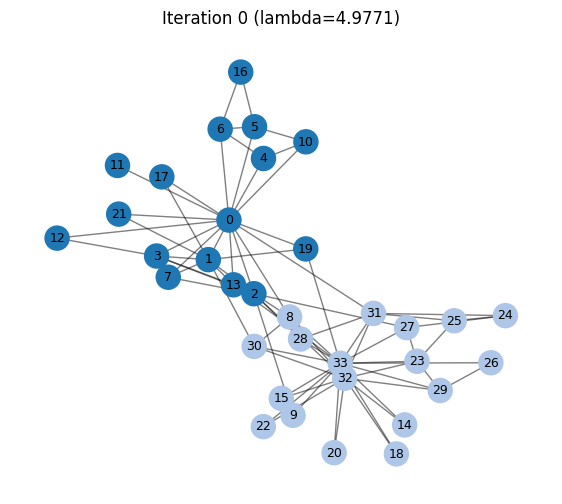

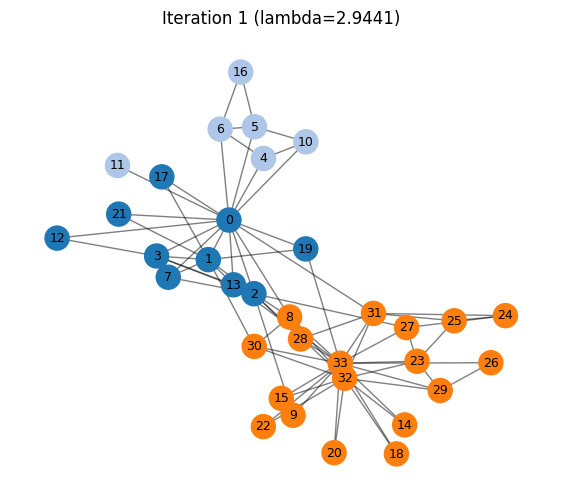

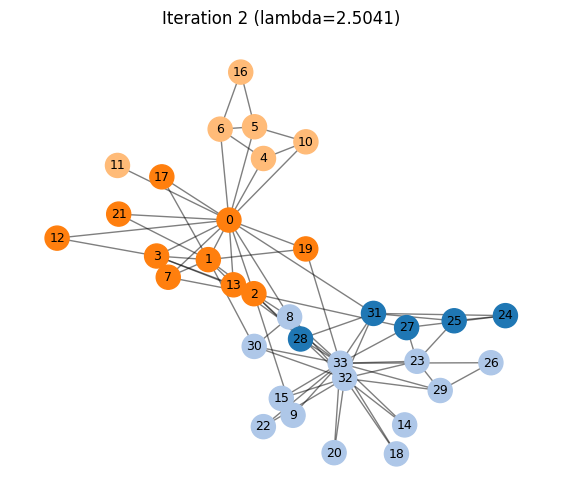

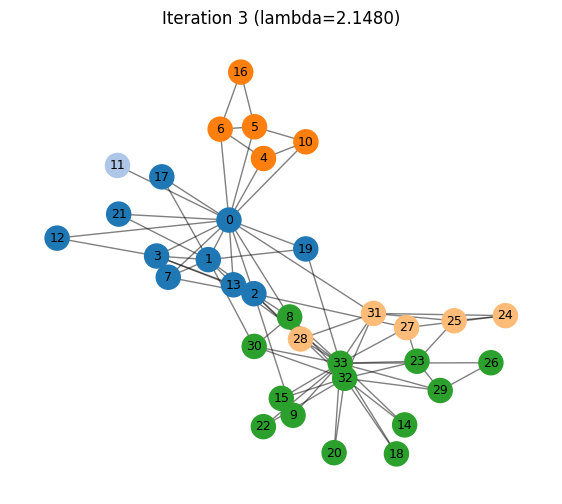

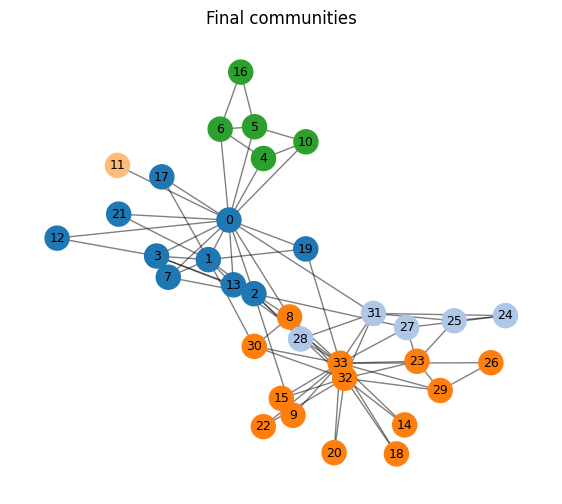

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os
# Cell 5: run algorithm and produce colored graphs per iteration

final_comms, snapshots = recursive_modularity_partition(G, min_size=1)

print("Final communities ({} communities):".format(len(final_comms)))
for i,c in enumerate(final_comms):
    print(f" C{i+1} (size {len(c)}): {c}")

# helper to draw and save colored graph image for a given communities list
def draw_communities(G, communities, pos, fname=None, title=None):
    # color map: assign one color per community using matplotlib cycle
    cmap = plt.get_cmap('tab20')
    color_map = {}
    for i,comm in enumerate(communities):
        for n in comm:
            color_map[n] = cmap(i % 20)
    node_colors = [color_map[n] for n in G.nodes()]

    plt.figure(figsize=(7,6))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title if title else "")
    plt.axis('off')
    if fname:
        plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

# Save and show snapshot images
for snap in snapshots:
    it = snap['iteration']
    comms = snap['communities']
    fname = os.path.join(outdir, f'communities_iter_{it}.png')
    title = f"Iteration {it} (lambda={snap['lambda']:.4f})"
    draw_communities(G, comms, pos, fname=fname, title=title)

# Also draw final partition
final_fname = os.path.join(outdir, 'final_communities.png')
draw_communities(G, final_comms, pos, fname=final_fname, title='Final communities')

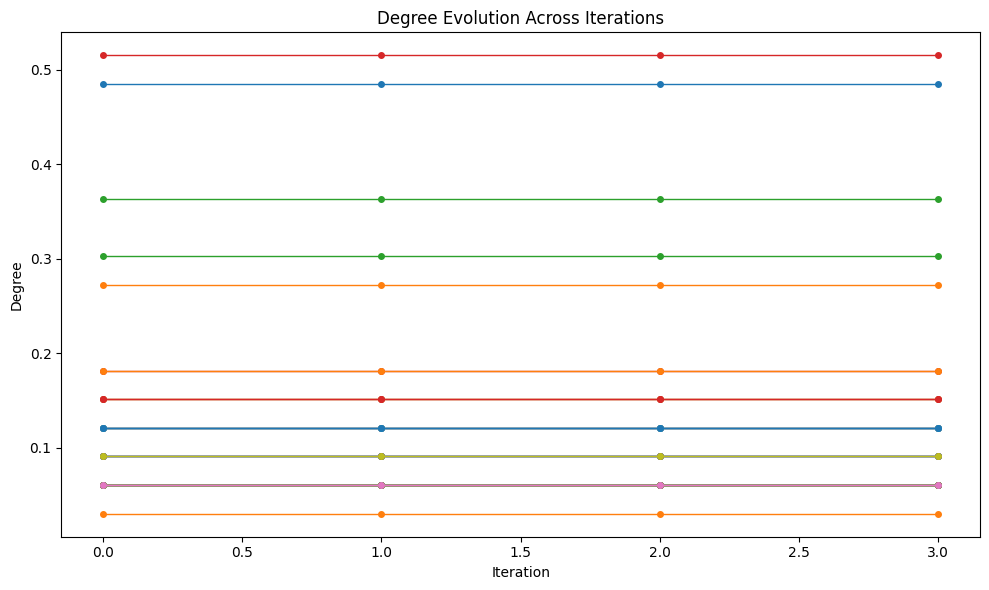

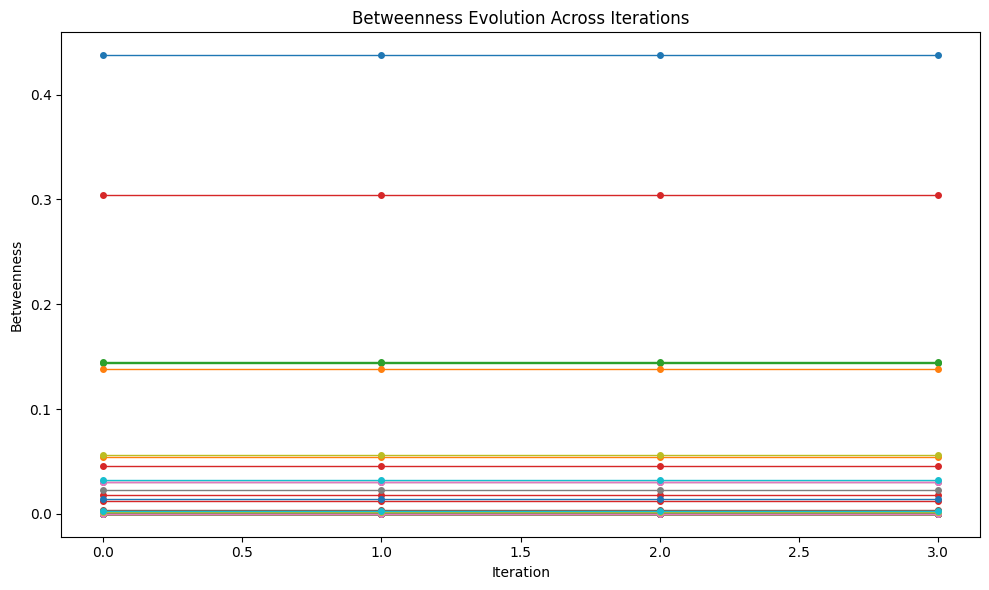

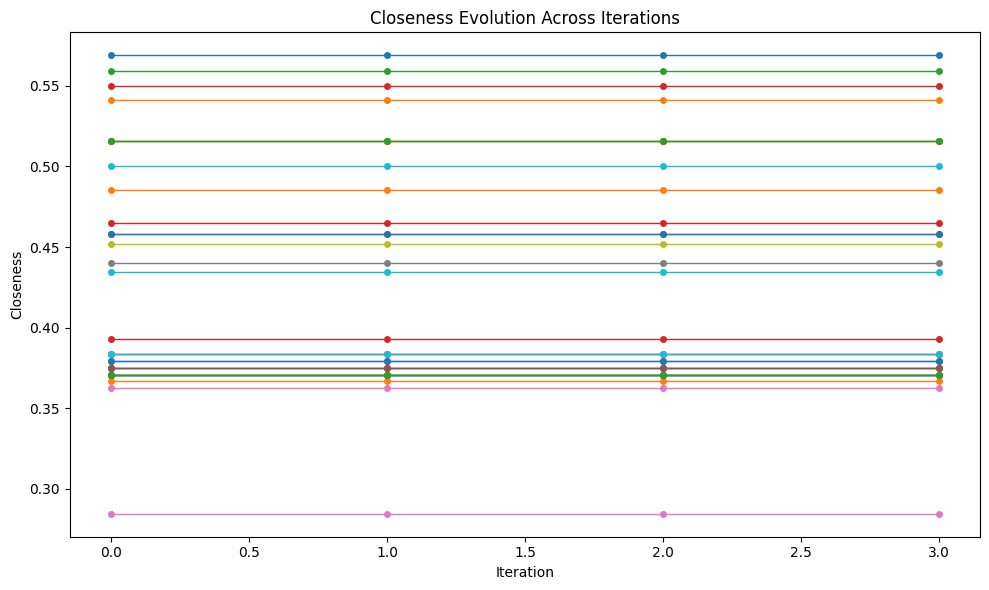

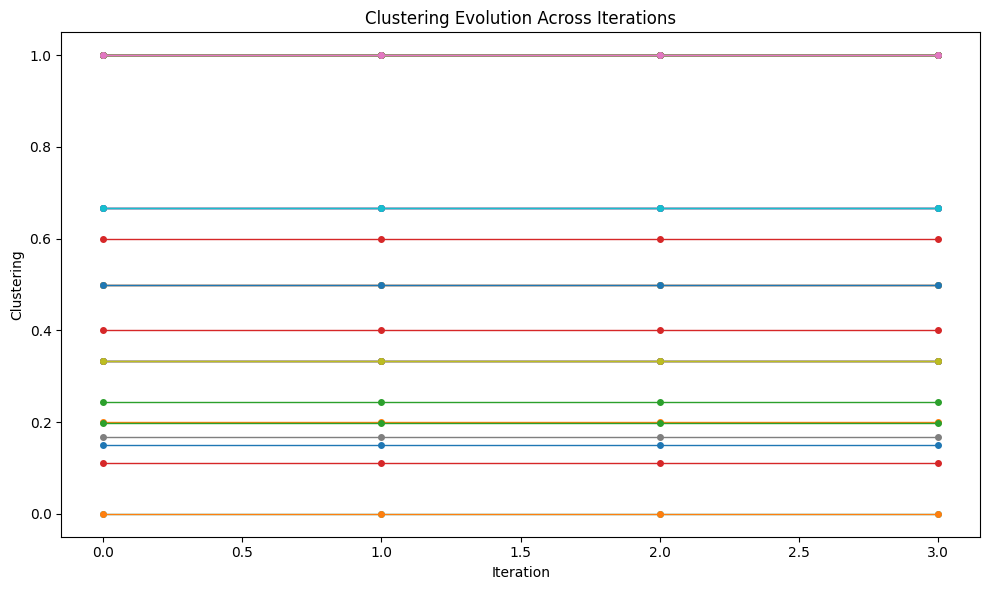

In [ ]:
# Cell 6 (Corrected): metric evolution across iterations
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os
metrics_names = ['degree', 'betweenness', 'closeness', 'clustering']

# Prepare evolution structure
evolution = {m: {n: [] for n in G.nodes()} for m in metrics_names}
iterations = []

for snap in snapshots:
    iterations.append(snap['iteration'])
    for m in metrics_names:
        metric_vals = snap['metrics'][m]
        for n in G.nodes():
            evolution[m][n].append(metric_vals.get(n, 0.0))


# --- Fixed plotting function (No legend, handles any number of iterations) ---
def plot_metric_evolution(metric_name, evolution_dict, iterations, fname=None):
    plt.figure(figsize=(10,6))

    for node, values in evolution_dict.items():
        # handle single-iteration case
        if len(iterations) == 1:
            plt.scatter(iterations, values, s=25)
        else:
            plt.plot(iterations, values, marker='o', linewidth=1, markersize=4)

    plt.xlabel("Iteration")
    plt.ylabel(metric_name.capitalize())
    plt.title(f"{metric_name.capitalize()} Evolution Across Iterations")
    plt.tight_layout()

    if fname:
        plt.savefig(fname, dpi=150)

    plt.show()
    plt.close()


# Create metrics directory
metric_dir = os.path.join(outdir, "metrics")
os.makedirs(metric_dir, exist_ok=True)

# Generate plots
for m in metrics_names:
    fname = os.path.join(metric_dir, f"metric_evolution_{m}.png")
    plot_metric_evolution(m, evolution[m], iterations, fname)

In [ ]:
# Cell 7: final modularity and short discussion printed

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import math
import os

Q_final = modularity_of_partition(G, final_comms)
print(f"Final modularity Q = {Q_final:.6f}")

# Identify consistently central nodes: we can inspect average rank across metrics across snapshots
avg_scores = {n: 0.0 for n in G.nodes()}
# We'll compute a simple aggregate score = average of normalized metric ranks across snapshots
for n in G.nodes():
    ranks = []
    for snap in snapshots:
        # for each snapshot, combine degree, betweenness, closeness, clustering into a single score via normalized sum
        vals = []
        vals.append(snap['metrics']['degree'][n])
        vals.append(snap['metrics']['betweenness'][n])
        vals.append(snap['metrics']['closeness'][n])
        vals.append(snap['metrics']['clustering'][n])
        ranks.append(np.mean(vals))
    avg_scores[n] = np.mean(ranks) if ranks else 0.0

# sort nodes by avg_scores descending
sorted_nodes = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)
print("\nNodes ranked by average metric score (higher -> more central/consistently important):")
for node,score in sorted_nodes[:10]:
    print(f" Node {node}: score {score:.4f}")

# Short discussion (printed)
print("\nDiscussion:")
print(" - The algorithm performs recursive bisection using the leading eigenvector of the modularity matrix.")
print(" - Final modularity above indicates how much better the partition is compared to random baseline (higher is better).")
print(" - As typical in the Karate dataset, a small number of nodes (e.g., node 0 and node 33 in classic numbering)")
print("   tend to remain central across splits because of high degree and bridging positions.")
print(" - The metric evolution plots (saved in the metrics folder) show how degree/betweenness/closeness/clustering")
print("   change as the community structure is refined. Bridge nodes often show oscillating betweenness when splits occur.")

Final modularity Q = 0.430146

Nodes ranked by average metric score (higher -> more central/consistently important):
 Node 0: score 0.4104
 Node 7: score 0.3903
 Node 33: score 0.3699
 Node 17: score 0.3589
 Node 21: score 0.3589
 Node 12: score 0.3578
 Node 14: score 0.3578
 Node 15: score 0.3578
 Node 18: score 0.3578
 Node 20: score 0.3578

Discussion:
 - The algorithm performs recursive bisection using the leading eigenvector of the modularity matrix.
 - Final modularity above indicates how much better the partition is compared to random baseline (higher is better).
 - As typical in the Karate dataset, a small number of nodes (e.g., node 0 and node 33 in classic numbering)
   tend to remain central across splits because of high degree and bridging positions.
 - The metric evolution plots (saved in the metrics folder) show how degree/betweenness/closeness/clustering
   change as the community structure is refined. Bridge nodes often show oscillating betweenness when splits occur.
